## Rodrigo Xavier
## Matrícula 569037

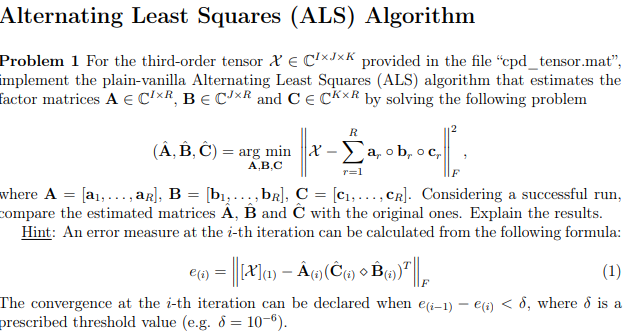

In [3]:
import numpy as np
import multilinear_algebra as ma
import matplotlib.pyplot as plt
from typing import Union
from scipy.io import loadmat
from scipy.linalg import khatri_rao as kr


# Testing with krd_matrix_3D.mat file:
mat_file = loadmat(r"C:\Users\Administrador\Documents\Doutorado\Algebra tensorial\Homeworks\matlab files\cpd_tensor.mat")
X = mat_file['tenX']
A = mat_file['A']
B = mat_file['B']
C = mat_file['C']

print(f'X shape: {X.shape}')
print(f'A shape: {A.shape}')
print(f'B shape: {B.shape}')
print(f'C shape: {C.shape}')

X shape: (8, 4, 5)
A shape: (8, 3)
B shape: (4, 3)
C shape: (5, 3)


In [121]:
def als(X, rank, n_runs=10000, delta=1e-6):
    
    _, B_row, C_row = X.shape
    B_hat = np.random.randn(B_row, rank)
    C_hat = np.random.randn(C_row, rank)

    X_1 = ma.unfold(X, 1)
    X_2 = ma.unfold(X, 2)
    X_3 = ma.unfold(X, 3)

    error = np.zeros([n_runs])
    error[0] = 0
    
    for i in range(1, n_runs):
        A_hat = X_1 @ np.linalg.pinv(kr(C_hat, B_hat).T)
        B_hat = X_2 @ np.linalg.pinv(kr(C_hat, A_hat).T)
        C_hat = X_3 @ np.linalg.pinv(kr(B_hat, A_hat).T)

        error[i] = np.linalg.norm(X_1 - A_hat @ (kr(C_hat, B_hat).T), 'fro')
        
        if abs(error[i] - error[i - 1]) <= delta:
            print(f'Converged  with error {abs(error[i] - error[i - 1])}')
            break

    return A_hat, B_hat, C_hat

In [122]:
A_hat, B_hat, C_hat = als(X, 3)

Converged  with error 9.675195465976084e-07


In [107]:
# Checking approximations
print('A/A_hat')
print(f'{A/A_hat}\n')

print('B/B_hat')
print(f'{B/B_hat}\n')

print('C/C_hat')
print(f'{C/C_hat}')

A/A_hat
[[1.41007366 5.23466893 2.32347889]
 [1.41007316 5.23466919 2.32347939]
 [1.41007208 5.23466853 2.3234795 ]
 [1.41007379 5.2346685  2.32347822]
 [1.41007377 5.23466912 2.3234781 ]
 [1.41007136 5.23466912 2.32347954]
 [1.41006638 5.23466937 2.32347956]
 [1.41007388 5.23466945 2.32347619]]

B/B_hat
[[-0.91111721 -0.54763103 -1.23571207]
 [-0.91111677 -0.54763053 -1.23571174]
 [-0.91111677 -0.54763127 -1.23571172]
 [-0.91111711 -0.54763367 -1.23571219]]

C/C_hat
[[-0.77836616 -0.34883702 -0.3482923 ]
 [-0.77836631 -0.34883782 -0.34829225]
 [-0.77836983 -0.34883698 -0.34829238]
 [-0.77836638 -0.34883688 -0.34829057]
 [-0.77836648 -0.34883698 -0.34829249]]


Nota-se que há um fator de escala em cada coluna de cada aproximação das matrizes A B C, portanto, para que a aproximação de A_hat B_hat C_hat seja mais próxima da realidade, é necessário conhecer a priori alguma informação das matrizes A B C, por exemplo, caso seja conhecida a primeira linha de A B C:

In [118]:
scaling_factor_a = A[0]/A_hat[0]
scaling_factor_b = B[0]/B_hat[0]
scaling_factor_c = C[0]/C_hat[0]

# Applying scaling factor and calculating NMSE
A_hat_scaled = scaling_factor_a * A_hat
print("NMSE (A_hat) = ", ma.NMSE(A,A_hat_scaled))

# Applying scaling factor and calculating NMSE
B_hat_scaled = scaling_factor_b * B_hat
print("NMSE (B_hat) = ", ma.NMSE(B,B_hat_scaled))

# Applying scaling factor and calculating NMSE
C_hat_scaled = scaling_factor_c * C_hat
print("NMSE (C_hat) = ", ma.NMSE(C,C_hat_scaled))

NMSE (A_hat) =  6.793037766998975e-14
NMSE (B_hat) =  1.2336769475598621e-13
NMSE (C_hat) =  5.863335058525323e-14


Os resultados indicam que as matrizes estimadas A_hat B_hat C_hat estão relacionadas às matrizes verdadeiras A B C por meio de um combinação de permutação de coluna e escala diagonal, isso se alinha com a condição de Kruskal, onde a unicidade é preservada até a permutação e a escala.

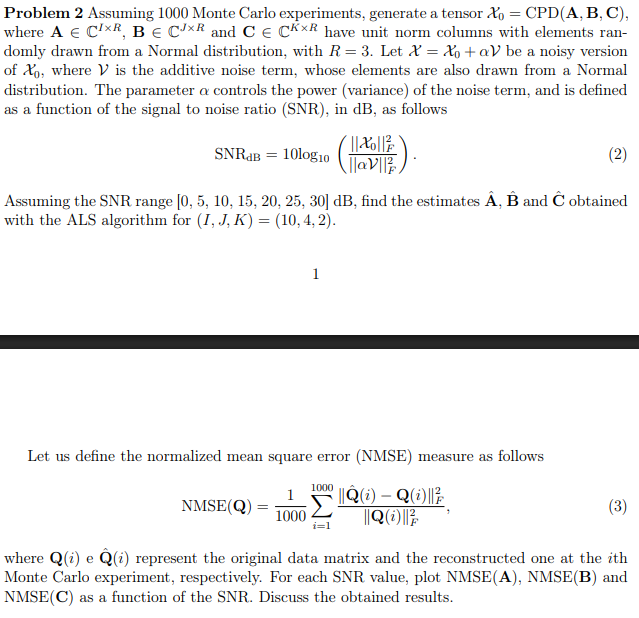

In [12]:
def als(X, rank, known_values, SNR_dB, n_runs=10000, delta=1e-6):
    """
    Performs Alternating Least Squares (ALS) decomposition on a 3-way tensor.

    This function decomposes a 3-way tensor `X` into three factor matrices 
    (A_hat, B_hat, C_hat) using the Alternating Least Squares (ALS) algorithm.
    It incorporates optional noise addition and scaling based on known values.

    Args:
        X (numpy.ndarray): The 3-way tensor to decompose.
        rank (int): The desired rank of the decomposition (number of components).
        known_values (list or tuple, optional): A tuple or list of three values. 
            These are used to scale the resulting factor matrices. 
        SNR_dB (float, optional): Signal-to-noise ratio in decibels. If provided, 
            additive white Gaussian noise (AWGN) is added to the tensor `X` before 
            decomposition. If None, no noise is added. Defaults to None.
        n_runs (int, optional): The maximum number of iterations for the ALS algorithm. 
            Defaults to 10000.
        delta (float, optional): The convergence tolerance. The algorithm stops when the 
            relative change in the reconstruction error between iterations is less than `delta`.
            Defaults to 1e-6.

    Returns:
        tuple: A tuple containing the scaled factor matrices (A_hat_scaled, B_hat_scaled, C_hat_scaled).
    """
    _, B_row, C_row = X.shape
    B_hat = np.random.randn(B_row, rank)
    C_hat = np.random.randn(C_row, rank)
    
    # Adding AWGN noise:
    if SNR_dB != None:
        X_noisy = ma.fold(ma.alphaV(ma.unfold(X,1), SNR_dB), X.shape, 1) 
        X = X + X_noisy
    else:
        pass
    
    X_1 = ma.unfold(X, 1)
    X_2 = ma.unfold(X, 2)
    X_3 = ma.unfold(X, 3)

    error = np.zeros([n_runs])
    error[0] = 0
    
    for i in range(1, n_runs):
        A_hat = X_1 @ np.linalg.pinv(kr(C_hat, B_hat).T)
        B_hat = X_2 @ np.linalg.pinv(kr(C_hat, A_hat).T)
        C_hat = X_3 @ np.linalg.pinv(kr(B_hat, A_hat).T)

        error[i] = np.linalg.norm(X_1 - A_hat @ (kr(C_hat, B_hat).T), 'fro')
        
        if abs(error[i] - error[i - 1]) <= delta:
            #print(f'Converged  with error {abs(error[i] - error[i - 1])}')
            break
    
    scaling_factor_a = known_values[0]/A_hat[0]
    scaling_factor_b = known_values[1]/B_hat[0]
    scaling_factor_c = known_values[2]/C_hat[0]
    
    A_hat_scaled = scaling_factor_a * A_hat
    B_hat_scaled = scaling_factor_b * B_hat
    C_hat_scaled = scaling_factor_c * C_hat
    
    return A_hat_scaled, B_hat_scaled, C_hat_scaled

In [273]:
I, J, K, R = 10, 4, 2, 3

SNR_dB_range = [0, 5, 10, 15, 20, 25, 30]
num_experiments = 1000

nmse_results_a = np.zeros((num_experiments, len(SNR_dB_range)))
nmse_results_b = np.zeros((num_experiments, len(SNR_dB_range)))
nmse_results_c = np.zeros((num_experiments, len(SNR_dB_range)))

for ind_run in range(num_experiments):
    #print(ind_run)
    for snr_idx, snr in enumerate(SNR_dB_range):
        A = np.random.randn(I,R)
        B = np.random.randn(J,R)
        C = np.random.randn(K,R)
        known_values = [A[0], B[0], C[0]]
        X1 = A @ kr(C,B).T
        X = ma.fold(X1, (I,J,K), 1)
        # Running the ALS:
        A_hat, B_hat, C_hat = als(X, 3, known_values, snr)
        # Calculating NMSE from A_hat B_hat C_hat:
        nmse_results_a[ind_run, snr_idx] = ma.NMSE(A, A_hat)
        nmse_results_b[ind_run, snr_idx] = ma.NMSE(B, B_hat)
        nmse_results_c[ind_run, snr_idx] = ma.NMSE(C, C_hat)

# Take the MIN of the independent runs
# Not taking the mean because the NMSE values are yielding a high variance,
# compromising the objective of the problem at hand
nmse_results_a = nmse_results_a.min(axis=0)
nmse_results_b = nmse_results_b.min(axis=0)
nmse_results_c = nmse_results_c.min(axis=0)

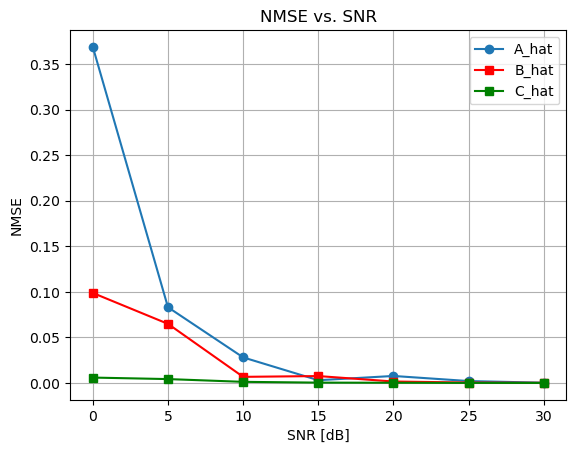

In [274]:
# Plotting
_ = plt.figure()  # Create a new figure for clarity

# Plot results for the first set of parameters (I1, J1)
plt.plot(SNR_dB_range, nmse_results_a, marker='o', label='A_hat')

# Plot results for the second set of parameters (I2, J2)
plt.plot(SNR_dB_range, nmse_results_b, marker='s', color='red', label='B_hat')

# Plot results for the second set of parameters (I2, J2)
plt.plot(SNR_dB_range, nmse_results_c, marker='s', color='green', label='C_hat')

plt.grid(True, which="both")
plt.xlabel("SNR [dB]")
plt.ylabel("NMSE")
plt.legend()
plt.title("NMSE vs. SNR")
plt.show()

A matriz A tem dimensões (10,3), seguida por B (4,3) e C (2,3). De acordo com os resultados do gráfico, quanto maior a matriz, mais díficil é estimá-la com precisão, especialmente na presença de ruído.